Importing packages:

In [2]:
from firedrake import *
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Initialising parameters, mesh, function spaces and functions:

In [39]:
epsilon = 1
k = 1

In [40]:
N = 10
mesh = UnitSquareMesh(N, N)

In [41]:
V = VectorFunctionSpace(mesh, "DG", degree=1, dim=2)
Q = FunctionSpace(mesh, "CG", degree=2)
W = V * Q

#do not implement Dirichlet bcs because for sin^2(pi*x)sin^2(pi*y) they happen to exist by design
#boundary_ids = (1, 2, 3, 4)
#bcs = DirichletBC(W.sub(1), 0, boundary_ids)

In [42]:
x, y = SpatialCoordinate(mesh)
u_exact = sin(pi*x)**2*sin(pi*y)**2
f = (-epsilon + k*1j)**2*u_exact + pi**2*(cos(2*pi*(x+y)) + cos(2*pi*(x-y)) - cos(2*pi*x) - cos(2*pi*y))

Implementing the pHSS iteration:

In [130]:
def pHSS_iteration(sigma_old, u_old, k, epsilon, f):
    sigma_new, u_new = TrialFunctions(W)
    tau, v = TestFunctions(W)
    
    #solving for u_new
    a = (Constant((-epsilon+1j)**2*k**2)*u_new*v*dx
         + inner(grad(u_new), grad(v))*dx
         - Constant((-epsilon+1j)*k**2)*u_new*v*dS)
    L = (Constant((k-1)/(k+1))*(Constant(-2*epsilon*k)*inner(sigma_old, grad(v))*dx
                                - inner(grad(u_old), grad(v))*dx
                                + Constant((epsilon**2 + 1)*k)*u_old*v*dx
                                - Constant((-epsilon+1j)*k**2)*u_old*v*dS)
         + Constant((-epsilon+1j)*2*k**2/((k+1)*(-epsilon+k*1j)))*f*v*dx)
    
    u_new = Function(Q)
    solve(a == L, u_new, solver_parameters={"ksp_type": "preonly",
                                            "pc_type": "lu",
                                            "pc_mat_factor_solver_type": "mumps",
                                            "mat_type": "aij"})
    
    #solving for sigma_new
    a = Constant((epsilon-1j)*k)*tau*sigma_new*dx
    L = (Constant((k-1)/(k+1))*(Constant((epsilon+1j)*k)*tau*sigma_old*dx
                                + inner(tau, grad(u_old))*dx)
         + inner(tau, grad(u_new)))
    
    sigma_new = Function(V)
    solve(a == L, sigma_new, solver_parameters={"ksp_type": "preonly",
                                                "pc_type": "lu",
                                                "pc_mat_factor_solver_type": "mumps",
                                                "mat_type": "aij"})
    
    return sigma_new, u_new

Testing the pHSS iteration:

In [131]:
sigma_old = interpolate(Constant((0,0), mesh), V)
u_old = interpolate(Constant(0, mesh), Q)

In [ ]:
pHSS_iteration(sigma_old, u_old, k, epsilon, f)

Implementing the pHSS algorithm:

In [134]:
def pHSS(sigma_0, u_0, k, epsilon, f, iters):
    sigma = sigma_0
    u = u_0
    
    for i in range(iters):
        sigma, u = pHSS_iteration(sigma, u, k, epsilon, f)
    
    return sigma, u

Testing the pHSS algorithm:

In [135]:
sigma_0 = interpolate(Constant((0,0), mesh), V)
u_0 = interpolate(Constant(0, mesh), Q)

In [ ]:
sigma, u = pHSS(sigma_0, u_0, k, epsilon, f, iters)

In [ ]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

quiver(sigma, axes=axes[0])
axes[0].set_aspect("equal")
axes[0].set_title("$\sigma$")

tripcolor(u, axes=axes[1])
axes[1].set_aspect("equal")
axes[1].set_title("$u$")

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots()
collection = tripcolor(u, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

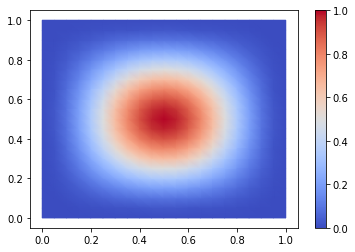

In [136]:
u_interpolated = assemble(interpolate(u_exact, Q))
fig, axes = plt.subplots()
collection = tripcolor(u_interpolated, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

In [ ]:
difference = assemble(interpolate(u_exact, Q) - uh)
fig, axes = plt.subplots()
collection = tripcolor(difference, axes=axes, cmap='coolwarm')
fig.colorbar(collection);